#### AIA Hub 第一次運行所需的套件

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade xgboost
# !pip install scikit-survival

#### GitLab Download Data

In [2]:
# !mkdir -p "Data"
# !mkdir -p "Data/Original"
# !wget -O "Data/Original/KIRC.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/KIRC.Data.mat?inline=false"
# !wget -O "Data/Original/LUSC.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/LUSC.Data.mat?inline=false"
# !wget -O "Data/Original/GBM.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/GBM.Data.mat?inline=false"
# !wget -O "Data/Original/OV.Data.mat" "https://gitlab.com/dwh1121/TCGA/raw/master/Data/Original/OV.Data.mat?inline=false"

In [3]:
import warnings
import numpy as np
import pandas as pd
import scipy.io as sio
import keras.backend as K
import matplotlib.pyplot as plt

from keras.regularizers import l2
from keras.models import Sequential
from keras.initializers import glorot_uniform
from keras.optimizers import SGD, RMSprop, Adam
from keras.layers import Dense, Activation, Dropout, Input
from keras.layers.normalization import BatchNormalization

from tqdm import tqdm
from xgboost import XGBRegressor

from sklearn import preprocessing
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from sksurv.meta import Stacking
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.svm import FastKernelSurvivalSVM, FastSurvivalSVM, NaiveSurvivalSVM
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis

Using TensorFlow backend.


In [4]:
warnings.simplefilter("ignore")

## 1. 載入特定癌別的 MATLAB 資料

In [5]:
mat_data = sio.loadmat("Data/Original/KIRC.Data.mat")

## 2. 將 MATLAB 整合成 DataFrame

### 2.1 統整 Available 與 Patients(Samples) 資料

Available 資料紀錄病患有做過哪些檢查
Samples(Patients) 為病人編號

In [6]:
AvailableList = np.array([
    "AvailableClinical",
    "AvailableProtein",
    "AvailablemRNA",
    "AvailableMutation",
    "AvailableCNV",
])

在 AvailableList 最前頭加入一個 Patients 欄位，並建立空白的 DataFrame

In [7]:
available_df = pd.DataFrame(columns=np.insert(AvailableList, 0, "Patients"))

把 Samples 病人編號放入 Patients 欄位

In [8]:
available_df["Patients"] = mat_data["Samples"]

把 Available 的文字資料轉為 Boolean 值後分別放入對應欄位

In [9]:
for AbleType in AvailableList:
    toList = []
    for i in range(len(mat_data[AbleType][0])):
        if mat_data["AvailablemRNA"][0][i][0] == "Yes":
            toList.append(True)
        elif mat_data["AvailablemRNA"][0][i][0] == "No":
            toList.append(False)
    available_df[AbleType] = toList

把 Patients 欄位設定成 index 並隨機抽樣看有無錯誤

In [10]:
available_df.set_index('Patients', inplace = True)
available_df.sample(5)

AvailableClinical  AvailableProtein  AvailablemRNA  \
Patients                                                              
TCGA-CJ-5671-01               True              True           True   
TCGA-A3-3387-01               True              True           True   
TCGA-B2-5635-01               True              True           True   
TCGA-G6-A8L7-01               True              True           True   
TCGA-CJ-4899-01               True              True           True   

                 AvailableMutation  AvailableCNV  
Patients                                          
TCGA-CJ-5671-01               True          True  
TCGA-A3-3387-01               True          True  
TCGA-B2-5635-01               True          True  
TCGA-G6-A8L7-01               True          True  
TCGA-CJ-4899-01               True          True

### 2.2 統整 Censored 與 Patients(Samples) 資料

1. T 代表轉置的表格，病人編號為欄位，之後會轉置回來
人工新增了 SymbolTypes 與 Symbols 欄位，方便未來與 Features 做整合
2. "1 - mat_data["Censored"]" 將生存事件轉為死亡事件

In [11]:
event_indicator_df_T = pd.DataFrame(1 - mat_data["Censored"], columns=mat_data["Samples"])
event_indicator_df_T.insert(loc=0, column='Symbols', value=["DeathEvent"])
event_indicator_df_T.insert(loc=0, column='SymbolTypes', value=["EventIndicator"])
event_indicator_df_T.head()

SymbolTypes     Symbols  TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  \
0  EventIndicator  DeathEvent              0.0              0.0   

   TCGA-A3-3306-01  TCGA-A3-3307-01  TCGA-A3-3308-01  TCGA-A3-3311-01  \
0              0.0              0.0              0.0              1.0   

   TCGA-A3-3313-01  TCGA-A3-3316-01       ...         TCGA-G6-A5PC-01  \
0              1.0              0.0       ...                     1.0   

   TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  \
0              1.0              0.0              1.0              0.0   

   TCGA-MM-A563-01  TCGA-MM-A564-01  TCGA-MM-A84U-01  TCGA-MW-A4EC-01  \
0              0.0              0.0              0.0              0.0   

   TCGA-T7-A92I-01  
0              0.0  

[1 rows x 539 columns]

### 2.3 統整 Survival 與 Patients(Samples) 資料

In [12]:
event_time_df_T = pd.DataFrame(mat_data["Survival"], columns=mat_data["Samples"])
event_time_df_T.insert(loc=0, column='Symbols', value=["SurvivalTime"])
event_time_df_T.insert(loc=0, column='SymbolTypes', value=["EventTime"])
event_time_df_T.head()

SymbolTypes       Symbols  TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  \
0   EventTime  SurvivalTime            385.0            362.0   

   TCGA-A3-3306-01  TCGA-A3-3307-01  TCGA-A3-3308-01  TCGA-A3-3311-01  \
0           1120.0           1436.0             16.0           1191.0   

   TCGA-A3-3313-01  TCGA-A3-3316-01       ...         TCGA-G6-A5PC-01  \
0            735.0           1493.0       ...                   242.0   

   TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  \
0            313.0           2133.0           1091.0             61.0   

   TCGA-MM-A563-01  TCGA-MM-A564-01  TCGA-MM-A84U-01  TCGA-MW-A4EC-01  \
0            591.0            607.0            700.0            498.0   

   TCGA-T7-A92I-01  
0            356.0  

[1 rows x 539 columns]

### 2.4 統整 Features 與 Patients(Samples) 資料

SymbolTypes 的原始資料有不明空白，故先移除後再放入

In [13]:
features_df_T = pd.DataFrame(mat_data["Features"], columns=mat_data["Samples"])
features_df_T.insert(loc=0, column='Symbols', value=list(map(lambda s: s.replace(' ' , ''), mat_data["Symbols"])))
features_df_T.insert(loc=0, column='SymbolTypes', value=list(map(lambda s: s.replace(' ' , ''), mat_data["SymbolTypes"])))

檢查 Features 的檢查類別(SymbolTypes)是否正確

In [14]:
pd.unique(features_df_T["SymbolTypes"])

array(['Clinical', 'Mutation', 'CNVGene', 'CNVArm', 'Protein', 'mRNA'], dtype=object)

取樣 Features 檢查

In [15]:
features_df_T.sample(5)

SymbolTypes                                            Symbols  \
31748        mRNA  NSUN6_mRNA                                    ...   
22554        mRNA  AFM_mRNA                                      ...   
12869    Mutation  PVR_Mut                                       ...   
36182        mRNA  STK38L_mRNA                                   ...   
33686        mRNA  PSTPIP2_mRNA                                  ...   

       TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
31748         166.8601         150.0270         225.6729         166.5138   
22554          20.7007          33.9989          13.9752          14.2202   
12869              NaN              NaN              NaN              NaN   
36182         485.5252         377.7658         872.1532         635.3211   
33686          70.2569         347.5445         825.5694         283.4862   

       TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  TCGA-A3-3316-01  \
31748         163.7803         158.4125         168.7211         223.8095   
22554          74.3204          10.6720           6.9337          34.0136   
12869           0.0000           0.0000              NaN           0.0000   
36182        1014.7953         661.3307         701.0786        1012.2449   
33686         103.6816         370.8521         196.4561         189.7959   

            ...         TCGA-G6-A5PC-01  TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  \
31748       ...                200.6247         253.5984         197.5560   
22554       ...                  0.0000           0.6854           1.0183   
12869       ...                     NaN              NaN              NaN   
36182       ...                215.3224         450.3084         260.6925   
33686       ...                193.2758         180.2605         290.2240   

       TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  TCGA-MM-A563-01  TCGA-MM-A564-01  \
31748         230.5516         163.0888         297.9899         243.8718   
22554           0.0000          10.8939           1.0050           5.6568   
12869              NaN              NaN              NaN              NaN   
36182         306.9391         942.6466         688.4422         512.8850   
33686         229.1627         149.6315         179.8995          38.9692   

       TCGA-MM-A84U-01  TCGA-MW-A4EC-01  TCGA-T7-A92I-01  
31748         220.8451         190.2614         132.2166  
22554           0.5634           1.2301           0.0000  
12869              NaN              NaN              NaN  
36182         529.0141         631.8811         262.9375  
33686         131.8310         205.0231         188.4535  

[5 rows x 539 columns]

### 2.5 依照檢查類別(SymbolTypes)做分組

共分為六類
1. Clinical
2. Mutation
3. CNVGene
4. CNVArm
5. Protein
6. mRNA

In [16]:
group_features_df_T = features_df_T.groupby(["SymbolTypes"])
group_features_df_T.head()

SymbolTypes                                            Symbols  \
0        Clinical  age_at_initial_pathologic_diagnosis_Clinical  ...   
1        Clinical  gender-Is-male_Clinical                       ...   
2        Clinical  histological_type-Is-kidney clear cell renal c...   
3        Clinical  pathologic_stage-Is-stage iii_Clinical        ...   
4        Clinical  pathologic_stage-Is-stage ii_Clinical         ...   
28       Mutation  A1BG_Mut                                      ...   
29       Mutation  A1CF_Mut                                      ...   
30       Mutation  A2BP1_Mut                                     ...   
31       Mutation  A2M_Mut                                       ...   
32       Mutation  A2ML1_Mut                                     ...   
18286     CNVGene  A4GNT_CNV                                     ...   
18287     CNVGene  AADAC_CNV                                     ...   
18288     CNVGene  AADACL2_CNV                                   ...   
18289     CNVGene  AADAT_CNV                                     ...   
18290     CNVGene  AARD_CNV                                      ...   
21945      CNVArm  1p_CNVArm                                     ...   
21946      CNVArm  2p_CNVArm                                     ...   
21947      CNVArm  2q_CNVArm                                     ...   
21948      CNVArm  3p_CNVArm                                     ...   
21949      CNVArm  3q_CNVArm                                     ...   
21973     Protein  YWHAB_Protein                                 ...   
21974     Protein  YWHAE_Protein                                 ...   
21975     Protein  YWHAZ_Protein                                 ...   
21976     Protein  EIF4EBP1_Protein                              ...   
21977     Protein  EIF4EBP1_Protein                              ...   
22208        mRNA  A1BG_mRNA                                     ...   
22209        mRNA  A1CF_mRNA                                     ...   
22210        mRNA  A2ML1_mRNA                                    ...   
22211        mRNA  A2M_mRNA                                      ...   
22212        mRNA  A4GALT_mRNA                                   ...   

       TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
0            69.000000        68.000000        67.000000          66.0000   
1             1.000000         0.000000         1.000000           1.0000   
2             1.000000         1.000000         1.000000           1.0000   
3             0.000000         0.000000         0.000000           1.0000   
4             0.000000         0.000000         0.000000           0.0000   
28                 NaN              NaN              NaN              NaN   
29                 NaN              NaN              NaN              NaN   
30                 NaN              NaN              NaN              NaN   
31                 NaN              NaN              NaN              NaN   
32                 NaN              NaN              NaN              NaN   
18286         0.000000         0.000000         0.000000           0.0000   
18287         0.000000         0.000000         0.000000           0.0000   
18288         0.000000         0.000000         0.000000           0.0000   
18289         0.000000         0.000000         0.000000           0.0000   
18290         0.000000         0.000000         0.000000           0.0000   
21945         0.000000         0.000000         0.000000           0.0000   
21946         0.375000         0.000000         0.000000           0.0000   
21947         0.375000         0.000000         0.000000           0.0000   
21948        -0.432000         0.000000        -0.635000          -0.5100   
21949         0.000000         0.000000         0.000000           0.0000   
21973         0.406331         0.315803        -0.084725              NaN   
21974        -0.053131        -0.015147        -0.117174              NaN   
21

Clinical 隨機取樣：

In [17]:
group_features_df_T.get_group("Clinical").sample(5)

SymbolTypes                                            Symbols  \
16    Clinical  pathologic_t-Is-t3b_Clinical                  ...   
0     Clinical  age_at_initial_pathologic_diagnosis_Clinical  ...   
1     Clinical  gender-Is-male_Clinical                       ...   
7     Clinical  pathologic_m-Is-m1_Clinical                   ...   
26    Clinical  race-Is-asian_Clinical                        ...   

    TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
16              0.0              0.0              0.0              1.0   
0              69.0             68.0             67.0             66.0   
1               1.0              0.0              1.0              1.0   
7               0.0              0.0              0.0              0.0   
26              0.0              0.0              0.0              NaN   

    TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  TCGA-A3-3316-01  \
16              1.0              0.0              0.0              0.0   
0              77.0             57.0             59.0             57.0   
1               0.0              1.0              1.0              1.0   
7               0.0              0.0              0.0              0.0   
26              0.0              NaN              0.0              0.0   

         ...         TCGA-G6-A5PC-01  TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  \
16       ...                     0.0              0.0              0.0   
0        ...                    54.0             55.0             81.0   
1        ...                     0.0              1.0              0.0   
7        ...                     1.0              0.0              0.0   
26       ...                     0.0              0.0              0.0   

    TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  TCGA-MM-A563-01  TCGA-MM-A564-01  \
16              0.0              0.0              0.0              0.0   
0              62.0             76.0             41.0             68.0   
1               0.0              0.0              1.0              1.0   
7               0.0              0.0              0.0              0.0   
26              0.0              0.0              0.0              0.0   

    TCGA-MM-A84U-01  TCGA-MW-A4EC-01  TCGA-T7-A92I-01  
16              0.0              0.0              0.0  
0              58.0             72.0             47.0  
1               0.0              0.0              0.0  
7               0.0              0.0              0.0  
26              0.0              0.0              0.0  

[5 rows x 539 columns]

Mutation 隨機取樣：

In [18]:
group_features_df_T.get_group("Mutation").sample(5)

SymbolTypes                                            Symbols  \
15631    Mutation  TBC1D13_Mut                                   ...   
6748     Mutation  GPR89A_Mut                                    ...   
9770     Mutation  MPPED1_Mut                                    ...   
7395     Mutation  HS3ST3B1_Mut                                  ...   
2189     Mutation  C2orf24_Mut                                   ...   

       TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
15631              NaN              NaN              NaN              NaN   
6748               NaN              NaN              NaN              NaN   
9770               NaN              NaN              NaN              NaN   
7395               NaN              NaN              NaN              NaN   
2189               NaN              NaN              NaN              NaN   

       TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  TCGA-A3-3316-01  \
15631              0.0              0.0              NaN              0.0   
6748               0.0              0.0              NaN              0.0   
9770               0.0              0.0              NaN              0.0   
7395               0.0              0.0              NaN              0.0   
2189               0.0              0.0              NaN              0.0   

            ...         TCGA-G6-A5PC-01  TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  \
15631       ...                     NaN              NaN              NaN   
6748        ...                     NaN              NaN              NaN   
9770        ...                     NaN              NaN              NaN   
7395        ...                     NaN              NaN              NaN   
2189        ...                     NaN              NaN              NaN   

       TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  TCGA-MM-A563-01  TCGA-MM-A564-01  \
15631              NaN              NaN              NaN              NaN   
6748               NaN              NaN              NaN              NaN   
9770               NaN              NaN              NaN              NaN   
7395               NaN              NaN              NaN              NaN   
2189               NaN              NaN              NaN              NaN   

       TCGA-MM-A84U-01  TCGA-MW-A4EC-01  TCGA-T7-A92I-01  
15631              NaN              NaN              NaN  
6748               NaN              NaN              NaN  
9770               NaN              NaN              NaN  
7395               NaN              NaN              NaN  
2189               NaN              NaN              NaN  

[5 rows x 539 columns]

CNVGene 隨機取樣：

In [19]:
group_features_df_T.get_group("CNVGene").sample(5)

SymbolTypes                                            Symbols  \
20429     CNVGene  OR2T34_CNV                                    ...   
18946     CNVGene  CRCT1_CNV                                     ...   
19711     CNVGene  IFT88_CNV                                     ...   
18438     CNVGene  APCS_CNV                                      ...   
19308     CNVGene  FAM83H_CNV                                    ...   

       TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
20429              0.0              0.0              0.0              0.0   
18946              0.0              0.0              0.0              0.0   
19711              0.0              0.0              0.0              0.0   
18438              0.0              0.0              0.0              0.0   
19308              0.0              0.0              0.0              0.0   

       TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  TCGA-A3-3316-01  \
20429              0.0              0.0              0.0              1.0   
18946              0.0              0.0              0.0              1.0   
19711              0.0              0.0              0.0              0.0   
18438              0.0              0.0              0.0              1.0   
19308              1.0              0.0              1.0              1.0   

            ...         TCGA-G6-A5PC-01  TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  \
20429       ...                     1.0              0.0              0.0   
18946       ...                     1.0              0.0              0.0   
19711       ...                     0.0              0.0             -1.0   
18438       ...                     1.0              0.0              0.0   
19308       ...                     0.0              0.0              0.0   

       TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  TCGA-MM-A563-01  TCGA-MM-A564-01  \
20429             -1.0              0.0              0.0              1.0   
18946              0.0              0.0              0.0              1.0   
19711              0.0              0.0              0.0              0.0   
18438              0.0              0.0              0.0              1.0   
19308              0.0              0.0              0.0              1.0   

       TCGA-MM-A84U-01  TCGA-MW-A4EC-01  TCGA-T7-A92I-01  
20429              0.0              0.0              0.0  
18946              0.0              0.0              0.0  
19711              0.0              0.0              0.0  
18438              0.0              0.0              0.0  
19308              0.0              0.0              0.0  

[5 rows x 539 columns]

CNVArm 隨機取樣：

In [20]:
group_features_df_T.get_group("CNVArm").sample(5)

SymbolTypes                                            Symbols  \
21963      CNVArm  12p_CNVArm                                    ...   
21948      CNVArm  3p_CNVArm                                     ...   
21959      CNVArm  8q_CNVArm                                     ...   
21954      CNVArm  6p_CNVArm                                     ...   
21971      CNVArm  20p_CNVArm                                    ...   

       TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
21963            0.000              0.0            0.000             0.00   
21948           -0.432              0.0           -0.635            -0.51   
21959            0.000              0.0            0.000             0.00   
21954            0.000              0.0           -0.686             0.00   
21971            0.399              0.0            0.000             0.00   

       TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  TCGA-A3-3316-01  \
21963            0.000            0.149            0.000            0.000   
21948            0.000           -0.498           -0.130           -0.405   
21959            0.711            0.000            0.344            0.366   
21954            0.000            0.000            0.346           -0.239   
21971            0.112            0.000            0.413            0.243   

            ...         TCGA-G6-A5PC-01  TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  \
21963       ...                     0.0            0.000            0.000   
21948       ...                     0.0           -0.638            0.000   
21959       ...                     0.0            0.000            0.000   
21954       ...                     0.0            0.000           -0.525   
21971       ...                     0.0            0.000            0.000   

       TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  TCGA-MM-A563-01  TCGA-MM-A564-01  \
21963            0.000            0.000            0.000            0.000   
21948           -0.851           -0.511           -0.587           -0.529   
21959            0.000            0.000           -0.588            0.304   
21954            0.000            0.000           -0.592            0.000   
21971            0.000            0.000            0.000            0.000   

       TCGA-MM-A84U-01  TCGA-MW-A4EC-01  TCGA-T7-A92I-01  
21963            0.000            0.000           -0.641  
21948           -0.579           -0.622            0.000  
21959            0.000            0.000            0.000  
21954            0.000            0.000            0.000  
21971            0.000            0.000            0.000  

[5 rows x 539 columns]

Protein 隨機取樣：

In [21]:
group_features_df_T.get_group("Protein").sample(5)

SymbolTypes                                            Symbols  \
22168     Protein  TSC1_Protein                                  ...   
22009     Protein  BCL2A1_Protein                                ...   
22057     Protein  FN1_Protein                                   ...   
22115     Protein  PDK1_Protein                                  ...   
22076     Protein  NRG1_Protein                                  ...   

       TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
22168        -0.010435        -0.077453        -0.226834              NaN   
22009         0.470881        -0.286334         0.491439              NaN   
22057         0.229477        -0.380452        -0.552968              NaN   
22115        -0.266126        -0.371173         0.189084              NaN   
22076         0.047818        -0.027710         0.113341              NaN   

       TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  TCGA-A3-3316-01  \
22168        -0.087120        -0.170681        -0.577076         0.007739   
22009         0.405820         0.243595        -0.514869        -0.092141   
22057         0.009679         0.157045        -0.073402         0.651760   
22115        -0.170618        -0.175114         0.026021        -0.019444   
22076        -0.412466        -0.096831         1.075696        -0.408829   

            ...         TCGA-G6-A5PC-01  TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  \
22168       ...                0.118761         0.181425        -0.407446   
22009       ...               -0.194737         0.227690        -0.059962   
22057       ...                0.077078        -0.778399        -0.270159   
22115       ...                0.065956        -0.032136        -0.133000   
22076       ...               -0.143009        -0.145919        -0.056536   

       TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  TCGA-MM-A563-01  TCGA-MM-A564-01  \
22168         0.182866        -0.151627         0.068595         0.109380   
22009         0.081916         0.569150        -0.211318        -0.071082   
22057        -0.672334         0.700931         0.006947         0.152850   
22115         0.268877        -0.544375         0.188239         0.246279   
22076        -0.075213         0.047849        -0.072885        -0.141293   

       TCGA-MM-A84U-01  TCGA-MW-A4EC-01  TCGA-T7-A92I-01  
22168              NaN         0.221240              NaN  
22009              NaN        -0.025805              NaN  
22057              NaN        -0.132586              NaN  
22115              NaN         0.101861              NaN  
22076              NaN         0.347268              NaN  

[5 rows x 539 columns]

mRNA 隨機取樣：

In [22]:
group_features_df_T.get_group("mRNA").sample(5)

SymbolTypes                                            Symbols  \
37044        mRNA  TMEM65_mRNA                                   ...   
24494        mRNA  CD300A_mRNA                                   ...   
24102        mRNA  CADPS_mRNA                                    ...   
26614        mRNA  EPHA3_mRNA                                    ...   
26995        mRNA  FAM98B_mRNA                                   ...   

       TCGA-3Z-A93Z-01  TCGA-6D-AA2E-01  TCGA-A3-3306-01  TCGA-A3-3307-01  \
37044         425.3050         314.6249         598.8613         457.3394   
24494         274.1273         132.7577         363.3540         398.1651   
24102           2.5092           5.9363           0.5176           1.3761   
26614         111.6583          52.8872         119.0476         540.3670   
26995         266.5998         281.7053         311.5942         308.7156   

       TCGA-A3-3308-01  TCGA-A3-3311-01  TCGA-A3-3313-01  TCGA-A3-3316-01  \
37044         677.6006         488.5776         832.0493         709.5238   
24494         362.4269         512.5896          94.3760         412.2449   
24102          16.9744           1.0005           1.1556           3.4014   
26614        1093.7034         617.9757         206.4715         506.8027   
26995         328.9368         353.5101         229.5840         453.7415   

            ...         TCGA-G6-A5PC-01  TCGA-G6-A8L6-01  TCGA-G6-A8L7-01  \
37044       ...                230.0202         413.9822         211.8126   
24494       ...                426.2355         604.5236         154.7862   
24102       ...                  0.0000          10.9664           0.0000   
26614       ...                 47.0329          66.4839         177.1894   
26995       ...                 83.0424         154.2152          75.3564   

       TCGA-G6-A8L8-01  TCGA-GK-A6C7-01  TCGA-MM-A563-01  TCGA-MM-A564-01  \
37044         403.6967         440.5639         443.2161         548.0830   
24494         124.9978         256.6485         536.1809         284.0981   
24102           1.8518           9.2919          26.1307          15.7134   
26614         129.1644         228.7728         314.5729         347.5801   
26995         102.3130         347.0042         233.6683         131.3639   

       TCGA-MM-A84U-01  TCGA-MW-A4EC-01  TCGA-T7-A92I-01  
37044         353.8028         416.1968         268.9201  
24494         430.9859         278.8314         107.3886  
24102           6.7606           3.6904           0.0000  
26614         171.2676         160.7381          31.1098  
26995         188.1690         235.3665         299.7308  

[5 rows x 539 columns]

### 2.6 依照檢查類別(SymbolTypes)分別與 EventIndicator、EventTime 整合後進行轉置

整理完成的 Clinical DataFrame

In [23]:
Clinical_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("Clinical")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableClinical"]].rename_axis("Patients", axis=0)
Clinical_df.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-BP-5191-01         0.0         967.0   
TCGA-B0-5712-01         0.0        2722.0   
TCGA-B8-5551-01         0.0          16.0   
TCGA-A3-3306-01         0.0        1120.0   
TCGA-BP-4769-01         0.0        1876.0   

Symbols          age_at_initial_pathologic_diagnosis_Clinical                     \
Patients                                                                           
TCGA-BP-5191-01                                               79.0                 
TCGA-B0-5712-01                                               68.0                 
TCGA-B8-5551-01                                               65.0                 
TCGA-A3-3306-01                                               67.0                 
TCGA-BP-4769-01                                               63.0                 

Symbols          gender-Is-male_Clinical                                          \
Patients                                                                           
TCGA-BP-5191-01                                                1.0                 
TCGA-B0-5712-01                                                0.0                 
TCGA-B8-5551-01                                                0.0                 
TCGA-A3-3306-01                                                1.0                 
TCGA-BP-4769-01                                                1.0                 

Symbols          histological_type-Is-kidney clear cell renal carcinoma_Clinical  \
Patients                                                                           
TCGA-BP-5191-01                                                1.0                 
TCGA-B0-5712-01                                                1.0                 
TCGA-B8-5551-01                                                1.0                 
TCGA-A3-3306-01                                                1.0                 
TCGA-BP-4769-01                                                1.0                 

Symbols          pathologic_stage-Is-stage iii_Clinical                           \
Patients                                                                           
TCGA-BP-5191-01                                                1.0                 
TCGA-B0-5712-01                                                0.0                 
TCGA-B8-5551-01                                                0.0                 
TCGA-A3-3306-01                                                0.0                 
TCGA-BP-4769-01                                                0.0                 

Symbols          pathologic_stage-Is-stage ii_Clinical                            \
Patients                                                                           
TCGA-BP-5191-01                                                0.0                 
TCGA-B0-5712-01                                                0.0                 
TCGA-B8-5551-01                                                0.0                 
TCGA-A3-3306-01                                                0.0                 
TCGA-BP-4769-01                                                0.0                 

Symbols          pathologic_stage-Is-stage i_Clinical                             \
Patients                                                                           
TCGA-BP-5191-01                                                0.0                 
TCGA-B0-5712-01                                                0.0                 
TCGA-B8-5551-01                                                1.0                 
TCGA-A3-3306-01                                                1.0                 
TCGA-BP-4769-01                                                1.0                 

Symbols          pathologic_stage-Is-stage iv_Clinical                            \
Patients                                                          

整理完成的 Mutation DataFrame

In [24]:
Mutation_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("Mutation")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableMutation"]].rename_axis("Patients", axis=0)
Mutation_df.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-A3-3319-01         0.0        1130.0   
TCGA-DV-A4VX-01         1.0        1626.0   
TCGA-CZ-5987-01         1.0         445.0   
TCGA-A3-3331-01         0.0        1485.0   
TCGA-A3-3343-01         0.0         945.0   

Symbols          A1BG_Mut                                                         \
Patients                                                                           
TCGA-A3-3319-01                                                0.0                 
TCGA-DV-A4VX-01                                                NaN                 
TCGA-CZ-5987-01                                                0.0                 
TCGA-A3-3331-01                                                NaN                 
TCGA-A3-3343-01                                                NaN                 

Symbols          A1CF_Mut                                                         \
Patients                                                                           
TCGA-A3-3319-01                                                0.0                 
TCGA-DV-A4VX-01                                                NaN                 
TCGA-CZ-5987-01                                                0.0                 
TCGA-A3-3331-01                                                NaN                 
TCGA-A3-3343-01                                                NaN                 

Symbols          A2BP1_Mut                                                        \
Patients                                                                           
TCGA-A3-3319-01                                                0.0                 
TCGA-DV-A4VX-01                                                NaN                 
TCGA-CZ-5987-01                                                0.0                 
TCGA-A3-3331-01                                                NaN                 
TCGA-A3-3343-01                                                NaN                 

Symbols          A2M_Mut                                                          \
Patients                                                                           
TCGA-A3-3319-01                                                0.0                 
TCGA-DV-A4VX-01                                                NaN                 
TCGA-CZ-5987-01                                                0.0                 
TCGA-A3-3331-01                                                NaN                 
TCGA-A3-3343-01                                                NaN                 

Symbols          A2ML1_Mut                                                        \
Patients                                                                           
TCGA-A3-3319-01                                                0.0                 
TCGA-DV-A4VX-01                                                NaN                 
TCGA-CZ-5987-01                                                0.0                 
TCGA-A3-3331-01                                                NaN                 
TCGA-A3-3343-01                                                NaN                 

Symbols          A4GALT_Mut                                                       \
Patients                                                                           
TCGA-A3-3319-01                                                0.0                 
TCGA-DV-A4VX-01                                                NaN                 
TCGA-CZ-5987-01                                                0.0                 
TCGA-A3-3331-01                                                NaN                 
TCGA-A3-3343-01                                                NaN                 

Symbols          A4GNT_Mut                                                        \
Patients                                                          

整理完成的 CNVGene DataFrame

In [25]:
CNVGene_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("CNVGene")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableCNV"]].rename_axis("Patients", axis=0)
CNVGene_df.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-BP-5192-01         0.0         714.0   
TCGA-A3-3346-01         1.0         137.0   
TCGA-CJ-4636-01         0.0        1924.0   
TCGA-B0-5107-01         1.0         927.0   
TCGA-A3-3383-01         0.0         861.0   

Symbols          A4GNT_CNV                                                        \
Patients                                                                           
TCGA-BP-5192-01                                                0.0                 
TCGA-A3-3346-01                                               -1.0                 
TCGA-CJ-4636-01                                                0.0                 
TCGA-B0-5107-01                                                0.0                 
TCGA-A3-3383-01                                                0.0                 

Symbols          AADAC_CNV                                                        \
Patients                                                                           
TCGA-BP-5192-01                                                0.0                 
TCGA-A3-3346-01                                               -1.0                 
TCGA-CJ-4636-01                                                0.0                 
TCGA-B0-5107-01                                                0.0                 
TCGA-A3-3383-01                                                0.0                 

Symbols          AADACL2_CNV                                                      \
Patients                                                                           
TCGA-BP-5192-01                                                0.0                 
TCGA-A3-3346-01                                               -1.0                 
TCGA-CJ-4636-01                                                0.0                 
TCGA-B0-5107-01                                                0.0                 
TCGA-A3-3383-01                                                0.0                 

Symbols          AADAT_CNV                                                        \
Patients                                                                           
TCGA-BP-5192-01                                                0.0                 
TCGA-A3-3346-01                                               -1.0                 
TCGA-CJ-4636-01                                               -1.0                 
TCGA-B0-5107-01                                                0.0                 
TCGA-A3-3383-01                                                0.0                 

Symbols          AARD_CNV                                                         \
Patients                                                                           
TCGA-BP-5192-01                                                0.0                 
TCGA-A3-3346-01                                                0.0                 
TCGA-CJ-4636-01                                                0.0                 
TCGA-B0-5107-01                                                0.0                 
TCGA-A3-3383-01                                                0.0                 

Symbols          AASS_CNV                                                         \
Patients                                                                           
TCGA-BP-5192-01                                                0.0                 
TCGA-A3-3346-01                                                0.0                 
TCGA-CJ-4636-01                                                1.0                 
TCGA-B0-5107-01                                                0.0                 
TCGA-A3-3383-01                                                0.0                 

Symbols          ABCB10_CNV                                                       \
Patients                                                          

整理完成的 CNVArm DataFrame

In [26]:
CNVArm_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("CNVArm")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableCNV"]].rename_axis("Patients", axis=0)
CNVArm_df.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-B0-5116-01         0.0        1274.0   
TCGA-BP-4330-01         0.0        1888.0   
TCGA-B0-5084-01         1.0         222.0   
TCGA-CJ-4640-01         0.0        3480.0   
TCGA-A3-3320-01         0.0        1508.0   

Symbols          1p_CNVArm                                                        \
Patients                                                                           
TCGA-B0-5116-01                                              0.000                 
TCGA-BP-4330-01                                              0.000                 
TCGA-B0-5084-01                                             -0.815                 
TCGA-CJ-4640-01                                             -0.036                 
TCGA-A3-3320-01                                              0.000                 

Symbols          2p_CNVArm                                                        \
Patients                                                                           
TCGA-B0-5116-01                                                0.0                 
TCGA-BP-4330-01                                                0.0                 
TCGA-B0-5084-01                                                0.0                 
TCGA-CJ-4640-01                                                0.0                 
TCGA-A3-3320-01                                                0.0                 

Symbols          2q_CNVArm                                                        \
Patients                                                                           
TCGA-B0-5116-01                                                0.0                 
TCGA-BP-4330-01                                                0.0                 
TCGA-B0-5084-01                                                0.0                 
TCGA-CJ-4640-01                                                0.0                 
TCGA-A3-3320-01                                                0.0                 

Symbols          3p_CNVArm                                                        \
Patients                                                                           
TCGA-B0-5116-01                                             -0.054                 
TCGA-BP-4330-01                                             -0.533                 
TCGA-B0-5084-01                                              0.308                 
TCGA-CJ-4640-01                                             -0.035                 
TCGA-A3-3320-01                                             -0.677                 

Symbols          3q_CNVArm                                                        \
Patients                                                                           
TCGA-B0-5116-01                                              0.366                 
TCGA-BP-4330-01                                              0.000                 
TCGA-B0-5084-01                                              0.555                 
TCGA-CJ-4640-01                                              0.413                 
TCGA-A3-3320-01                                              0.000                 

Symbols          4p_CNVArm                                                        \
Patients                                                                           
TCGA-B0-5116-01                                             -0.368                 
TCGA-BP-4330-01                                              0.000                 
TCGA-B0-5084-01                                             -0.812                 
TCGA-CJ-4640-01                                              0.000                 
TCGA-A3-3320-01                                              0.000                 

Symbols          4q_CNVArm                                                        \
Patients                                                          

整理完成的 Protein DataFrame

In [27]:
Protein_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("Protein")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailableProtein"]].rename_axis("Patients", axis=0)
Protein_df.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-B8-5159-01         0.0         722.0   
TCGA-BP-4763-01         1.0        1270.0   
TCGA-B8-A54E-01         0.0         909.0   
TCGA-CJ-4885-01         0.0        3451.0   
TCGA-BP-4967-01         0.0         205.0   

Symbols          YWHAB_Protein                                                    \
Patients                                                                           
TCGA-B8-5159-01                                          -0.093285                 
TCGA-BP-4763-01                                           0.051096                 
TCGA-B8-A54E-01                                           0.382692                 
TCGA-CJ-4885-01                                           0.210567                 
TCGA-BP-4967-01                                           0.093714                 

Symbols          YWHAE_Protein                                                    \
Patients                                                                           
TCGA-B8-5159-01                                          -0.102953                 
TCGA-BP-4763-01                                           0.011236                 
TCGA-B8-A54E-01                                           0.436749                 
TCGA-CJ-4885-01                                           0.137965                 
TCGA-BP-4967-01                                          -0.138173                 

Symbols          YWHAZ_Protein                                                    \
Patients                                                                           
TCGA-B8-5159-01                                          -0.067741                 
TCGA-BP-4763-01                                          -0.043200                 
TCGA-B8-A54E-01                                          -0.428023                 
TCGA-CJ-4885-01                                          -0.643359                 
TCGA-BP-4967-01                                          -0.503106                 

Symbols          EIF4EBP1_Protein                                                 \
Patients                                                                           
TCGA-B8-5159-01                                           0.012198                 
TCGA-BP-4763-01                                          -0.169509                 
TCGA-B8-A54E-01                                          -0.166347                 
TCGA-CJ-4885-01                                          -0.209376                 
TCGA-BP-4967-01                                          -0.372976                 

Symbols          EIF4EBP1_Protein                                                 \
Patients                                                                           
TCGA-B8-5159-01                                           0.229448                 
TCGA-BP-4763-01                                          -0.250924                 
TCGA-B8-A54E-01                                          -0.417574                 
TCGA-CJ-4885-01                                           0.120710                 
TCGA-BP-4967-01                                           0.031387                 

Symbols          EIF4EBP1_Protein                                                 \
Patients                                                                           
TCGA-B8-5159-01                                          -0.370189                 
TCGA-BP-4763-01                                           0.558919                 
TCGA-B8-A54E-01                                          -0.172737                 
TCGA-CJ-4885-01                                          -0.662974                 
TCGA-BP-4967-01                                          -0.315134                 

Symbols          EIF4EBP1_Protein                                                 \
Patients                                                          

整理完成的 mRNA DataFrame

In [28]:
mRNA_df = pd.concat([event_indicator_df_T, event_time_df_T, group_features_df_T.get_group("mRNA")]).set_index('Symbols').iloc[:,1:].T[available_df["AvailablemRNA"]].rename_axis("Patients", axis=0)
mRNA_df.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-BP-4756-01         0.0         374.0   
TCGA-CZ-5467-01         1.0          73.0   
TCGA-B0-4828-01         1.0         307.0   
TCGA-B0-5110-01         0.0        2009.0   
TCGA-A3-3349-01         0.0        1385.0   

Symbols          A1BG_mRNA                                                        \
Patients                                                                           
TCGA-BP-4756-01                                            58.1248                 
TCGA-CZ-5467-01                                            28.2719                 
TCGA-B0-4828-01                                            34.7474                 
TCGA-B0-5110-01                                            33.4665                 
TCGA-A3-3349-01                                            53.2646                 

Symbols          A1CF_mRNA                                                        \
Patients                                                                           
TCGA-BP-4756-01                                            92.1659                 
TCGA-CZ-5467-01                                           122.8056                 
TCGA-B0-4828-01                                            97.8717                 
TCGA-B0-5110-01                                           350.7214                 
TCGA-A3-3349-01                                           127.0227                 

Symbols          A2ML1_mRNA                                                       \
Patients                                                                           
TCGA-BP-4756-01                                             0.0000                 
TCGA-CZ-5467-01                                             0.3328                 
TCGA-B0-4828-01                                             0.5791                 
TCGA-B0-5110-01                                             0.3700                 
TCGA-A3-3349-01                                             0.0000                 

Symbols          A2M_mRNA                                                         \
Patients                                                                           
TCGA-BP-4756-01                                          7717.6746                 
TCGA-CZ-5467-01                                         56408.6297                 
TCGA-B0-4828-01                                          9312.8131                 
TCGA-B0-5110-01                                         46173.1003                 
TCGA-A3-3349-01                                         53143.7176                 

Symbols          A4GALT_mRNA                                                      \
Patients                                                                           
TCGA-BP-4756-01                                           920.2410                 
TCGA-CZ-5467-01                                          1540.8936                 
TCGA-B0-4828-01                                          1863.6166                 
TCGA-B0-5110-01                                          1051.7943                 
TCGA-A3-3349-01                                          1554.2071                 

Symbols          A4GNT_mRNA                                                       \
Patients                                                                           
TCGA-BP-4756-01                                             9.2166                 
TCGA-CZ-5467-01                                             3.9937                 
TCGA-B0-4828-01                                            24.9023                 
TCGA-B0-5110-01                                            25.1572                 
TCGA-A3-3349-01                                            33.1715                 

Symbols          AAAS_mRNA                                                        \
Patients                                                          

## 3. 挑選輸入的資料，並切分訓練與測試集

### 3.1 挑選一個上述整理完的 DataFrame

In [29]:
input_data = Protein_df
input_data.shape

(533, 237)

### 3.2 整理資料

重新命名同名稱的 Column

In [30]:
cols=pd.Series(input_data.columns)
for dup in input_data.columns.get_duplicates(): cols[input_data.columns.get_loc(dup)]=[dup+'.'+str(d_idx) if d_idx!=0 else dup for d_idx in range(input_data.columns.get_loc(dup).sum())]
input_data.columns=cols

處理缺失值

In [31]:
# input_data.dropna(axis = 0,inplace = True)
# input_data.dropna(axis = 1,inplace = True)
# input_data.fillna(0, inplace = True)
input_data.fillna(input_data.mean(), inplace = True)
input_data.shape

(533, 237)

標準化

In [32]:
# scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
input_data.iloc[:,2:] = scaler.fit_transform(input_data.iloc[:,2:])

把 Death Event 轉成 Boolean 值，才能進行 Cox 訓練

In [33]:
input_data["DeathEvent"] = input_data["DeathEvent"].astype(bool)

取樣檢查

In [34]:
input_data.sample(5)

Symbols          DeathEvent  SurvivalTime  \
Patients                                    
TCGA-A3-3323-01       False        1106.0   
TCGA-BP-5173-01        True          62.0   
TCGA-BP-5191-01       False         967.0   
TCGA-B0-4845-01        True        1986.0   
TCGA-B0-4810-01        True         478.0   

Symbols          YWHAB_Protein                                                    \
Patients                                                                           
TCGA-A3-3323-01                                           0.250558                 
TCGA-BP-5173-01                                          -1.059742                 
TCGA-BP-5191-01                                          -0.888069                 
TCGA-B0-4845-01                                          -0.084062                 
TCGA-B0-4810-01                                          -0.844667                 

Symbols          YWHAE_Protein                                                    \
Patients                                                                           
TCGA-A3-3323-01                                          -0.085262                 
TCGA-BP-5173-01                                          -1.172262                 
TCGA-BP-5191-01                                          -0.604956                 
TCGA-B0-4845-01                                          -0.328678                 
TCGA-B0-4810-01                                          -0.654045                 

Symbols          YWHAZ_Protein                                                    \
Patients                                                                           
TCGA-A3-3323-01                                          -0.654401                 
TCGA-BP-5173-01                                          -0.829829                 
TCGA-BP-5191-01                                           0.462283                 
TCGA-B0-4845-01                                          -0.287978                 
TCGA-B0-4810-01                                           0.231747                 

Symbols          EIF4EBP1_Protein                                               .1  \
Patients                                                                             
TCGA-A3-3323-01                                           0.882455                   
TCGA-BP-5173-01                                          -0.786682                   
TCGA-BP-5191-01                                           0.039636                   
TCGA-B0-4845-01                                           0.085290                   
TCGA-B0-4810-01                                           1.199756                   

Symbols          EIF4EBP1_Protein                                               .2  \
Patients                                                                             
TCGA-A3-3323-01                                          -1.347739                   
TCGA-BP-5173-01                                           0.936632                   
TCGA-BP-5191-01                                          -0.573026                   
TCGA-B0-4845-01                                          -1.175286                   
TCGA-B0-4810-01                                           2.673377                   

Symbols          EIF4EBP1_Protein                                               .3  \
Patients                                                                             
TCGA-A3-3323-01                                          -0.779534                   
TCGA-BP-5173-01                                           0.229612                   
TCGA-BP-5191-01                                          -0.140338                   
TCGA-B0-4845-01                                           0.835033                   
TCGA-B0-4810-01                                           2.714195                   

Symbols          EIF4EBP1_Protein                                                 \
Patients                

### 3.2 切分資料

y 值為 DeathEvent、SurvivalTime

In [35]:
X = input_data.iloc[:,2:]
y = input_data.iloc[:,:2].to_records(index = False)

## 4. 宣告模型函數

訓練模型並回傳 C-index

In [36]:
def get_c_index(model_name, X_train, y_train, X_test, y_test):
    estimator = model_list[model_name]
    estimator.fit(X_train, y_train)
    
    pred_risk_train = estimator.predict(X_train)
    c_index_train = concordance_index_censored(y_train["DeathEvent"], y_train["SurvivalTime"], pred_risk_train)[0]
    
    pred_risk_test = estimator.predict(X_test)
    c_index_test = concordance_index_censored(y_test["DeathEvent"], y_test["SurvivalTime"], pred_risk_test)[0]
    
    res = {
        "ModelName": model_name,
        "C-index Train": c_index_train,
        "C-index Test": c_index_test,
    }
    
    return res

Deep Surv 的模型 Class

In [37]:
class DeepSurvOri:
    def __init__(self):
        #Keras model
        self.model = Sequential()
        self.model.add(Dense(32, input_shape=(X.shape[1],),
                        kernel_initializer=glorot_uniform())) # shape= length, dimension
        self.model.add(Activation('relu'))
        self.model.add(Dense(32, kernel_initializer=glorot_uniform()))
        self.model.add(Activation('relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(1, activation="linear",
                        kernel_initializer=glorot_uniform(),
                        kernel_regularizer=l2(0.01),
                        activity_regularizer=l2(0.01)))

        self.sgd = SGD(lr=1e-5, decay=0.01, momentum=0.9, nesterov=True)
        # self.rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
        
    #Loss Function
    def __negative_log_likelihood(self, E):
        def loss(y_true, y_pred):
            hazard_ratio = K.exp(y_pred)
            log_risk = K.log(K.cumsum(hazard_ratio, axis=1))
            uncensored_likelihood = y_pred - log_risk
            censored_likelihood = uncensored_likelihood * E
            neg_likelihood = -K.sum(censored_likelihood)
            return neg_likelihood
        return loss
        
    def fit(self, X, y):
        X = np.array(X)
        Y = y["SurvivalTime"]
        E = y["DeathEvent"].astype(int)
        
        #Sorting for NNL!
        sort_idx = np.argsort(Y)[::-1]
        X = X[sort_idx]
        Y = Y[sort_idx]
        E = E[sort_idx]
        
        self.model.compile(loss=self.__negative_log_likelihood(E), optimizer=self.sgd)
        
        self.model.fit(X, Y, batch_size=len(X), epochs=1000, verbose=False, shuffle=False)  # Shuffle False --> Important!!
        
    def predict(self, X):
        self.pred = -np.exp(self.model.predict(X))
        self.risk = []
        for e in self.pred:
            self.risk.append(e[0])
        return self.risk

In [38]:
class DeepSurv:
    def __init__(self):
        # Keras model
        self.model = Sequential()
        
        self.model.add(Dense(
            16,
            input_shape=(X.shape[1],),
            kernel_initializer=glorot_uniform()
        ))
        self.model.add(BatchNormalization())
        self.model.add(Activation('relu'))
        
        for i in range(5):
            self.model.add(Dense(16, kernel_initializer=glorot_uniform()))
            self.model.add(BatchNormalization())
            self.model.add(Activation('relu'))
        
        self.model.add(Dense(1, kernel_initializer=glorot_uniform()))
        self.model.add(BatchNormalization())
        self.model.add(Activation('linear'))

        self.sgd = SGD(lr=1e-5, decay=0.01, momentum=0.9, nesterov=True)
        # self.rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
        # self.adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.01, amsgrad=True)
        
    #Loss Function
    def __negative_log_likelihood(self, E):
        def loss(y_true, y_pred):
            hazard_ratio = K.exp(y_pred)
            log_risk = K.log(K.cumsum(hazard_ratio, axis=1))
            uncensored_likelihood = y_pred - log_risk
            censored_likelihood = uncensored_likelihood * E
            neg_likelihood = -K.sum(censored_likelihood)
            return neg_likelihood
        return loss
        
    def fit(self, X, y):
        X = np.array(X)
        Y = y["SurvivalTime"]
        E = y["DeathEvent"].astype(int)
        
        #Sorting for NNL!
        sort_idx = np.argsort(Y)[::-1]
        X = X[sort_idx]
        Y = Y[sort_idx]
        E = E[sort_idx]
        
        self.model.compile(loss=self.__negative_log_likelihood(E), optimizer=self.sgd)
        
        self.model.fit(X, Y, batch_size=len(X), epochs=1000, verbose=False, shuffle=False)  # Shuffle False --> Important!!
        
    def predict(self, X):
        self.pred = -np.exp(self.model.predict(X))
        self.risk = []
        for e in self.pred:
            self.risk.append(e[0])
        return self.risk

Deep Residual 的模型 Class

In [39]:
import keras
class DeepResidual:
    def __init__(self):
        self.input = keras.layers.Input(shape=(X.shape[1],))
        
        self.dense1 = keras.layers.Dense(16, kernel_initializer=glorot_uniform())(self.input)
        self.bn1 = keras.layers.normalization.BatchNormalization()(self.dense1)
        self.act1 = keras.layers.Activation('relu')(self.bn1)
        
        self.shortcut1 = self.__shortcut_block(self.act1)
        self.shortcut2 = self.__shortcut_block(self.shortcut1)
        self.shortcut3 = self.__shortcut_block(self.shortcut2)
        self.shortcut4 = self.__shortcut_block(self.shortcut3)
        self.shortcut5 = self.__shortcut_block(self.shortcut4)
        self.shortcut6 = self.__shortcut_block(self.shortcut5)
        
        self.out = keras.layers.Dense(1)(self.shortcut6)
        self.model = keras.models.Model(inputs=self.input, outputs=self.out)

        self.sgd = SGD(lr=1e-5, decay=0.01, momentum=0.9, nesterov=True)
        # self.rmsprop = RMSprop(lr=1e-5, rho=0.9, epsilon=1e-8)
        # self.adam = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-8, decay=0.01, amsgrad=True)
        
    #Loss Function
    def __negative_log_likelihood(self, E):
        def loss(y_true, y_pred):
            hazard_ratio = K.exp(y_pred)
            log_risk = K.log(K.cumsum(hazard_ratio, axis=1))
            uncensored_likelihood = y_pred - log_risk
            censored_likelihood = uncensored_likelihood * E
            neg_likelihood = -K.sum(censored_likelihood)
            return neg_likelihood
        return loss
    
    def __shortcut_block(self, prev_input):
        dense = keras.layers.Dense(16, kernel_initializer=glorot_uniform())(prev_input)
        bn = keras.layers.normalization.BatchNormalization()(dense)
        act = keras.layers.Activation('relu')(bn)
        shortcut = keras.layers.add([prev_input, act])
        return shortcut
        
    def fit(self, X, y):
        X = np.array(X)
        Y = y["SurvivalTime"]
        E = y["DeathEvent"].astype(int)
        
        #Sorting for NNL!
        sort_idx = np.argsort(Y)[::-1]
        X = X[sort_idx]
        Y = Y[sort_idx]
        E = E[sort_idx]
        
        self.model.compile(loss=self.__negative_log_likelihood(E), optimizer=self.sgd)
        
        self.model.fit(X, Y, batch_size=len(X), epochs=1000, verbose=False, shuffle=False)  # Shuffle False --> Important!!
        
    def predict(self, X):
        self.pred = -np.exp(self.model.predict(X))
        self.risk = []
        for e in self.pred:
            self.risk.append(e[0])
        return self.risk

XGBoost 的模型 Class

In [40]:
class XGBoostSurvival:
    def __init__(self):
        self.xgb = XGBRegressor(
            objective = 'survival:cox',
            eval_metric = 'cox-nloglik',
            max_depth=9,
        )
        
    def fit(self, X, y):
        self.xgb.fit(X, y["SurvivalTime"], y["DeathEvent"])
        
    def predict(self, X):
        return self.xgb.predict(X)

建立一個空 DataFrame 存 C-index 結果

In [41]:
all_c_index = pd.DataFrame(columns=["ModelName", "C-index Train", "C-index Test"])

建立模型清單，跑回圈多次重切訓練與測試資料並取平均

In [42]:
now = 0
loops = 20
pbar = tqdm(total=loops)
while (now < loops):
    K.clear_session()
    
    model_list = {
        # "cox": CoxPHSurvivalAnalysis(),
        "coxnet": CoxnetSurvivalAnalysis(),
        "cgbs": ComponentwiseGradientBoostingSurvivalAnalysis(),
        "gbs": GradientBoostingSurvivalAnalysis(),
        "fksvm_linear": FastKernelSurvivalSVM(kernel="linear"),
        "fksvm_poly": FastKernelSurvivalSVM(kernel="poly"),
        "fksvm_rbf": FastKernelSurvivalSVM(kernel="rbf"),
        "fksvm_cosine": FastKernelSurvivalSVM(kernel="cosine"),
        "fsvm": FastSurvivalSVM(),
        "nsvm": NaiveSurvivalSVM(),
        "xgb_surv": XGBoostSurvival(),
        "deep_surv": DeepSurv(),
        "deep_surv_ori": DeepSurvOri(),
        "deep_residual": DeepResidual(),
        "stacking_a": Stacking(
            meta_estimator=GradientBoostingSurvivalAnalysis(),
            base_estimators=[
                # ["cox",CoxPHSurvivalAnalysis()],
                ["coxnet",CoxnetSurvivalAnalysis()],
                ["cgbs",ComponentwiseGradientBoostingSurvivalAnalysis()],
                ["gbs",GradientBoostingSurvivalAnalysis()],
                ["fksvm_linear",FastKernelSurvivalSVM(kernel="linear")],
                ["fksvm_poly",FastKernelSurvivalSVM(kernel="poly")],
                ["fksvm_rbf",FastKernelSurvivalSVM(kernel="rbf")],
                ["fksvm_cosine",FastKernelSurvivalSVM(kernel="cosine")],
                ["fsvm",FastSurvivalSVM()],
                ["nsvm",NaiveSurvivalSVM()],
            ]
        ),
    }
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
#     for model_name in model_list:
#         all_c_index = all_c_index.append(get_c_index(model_name, X_train, y_train, X_test, y_test), ignore_index=True)
#     now += 1
#     pbar.update(1)
    
    try:
        for model_name in model_list:
            all_c_index = all_c_index.append(get_c_index(model_name, X_train, y_train, X_test, y_test), ignore_index=True)
        now += 1
        pbar.update(1)
    except:
        print("Some Error")
        continue
        
pbar.close()

100%|██████████| 10/10 [36:21<00:00, 211.46s/it]


In [43]:
group_c_index = all_c_index.groupby("ModelName")

In [44]:
boxplot_data = {
    "train": [],
    "test": [],
    "labels": [],
}
mean_c_index = pd.DataFrame(columns=["ModelName", "Median C-index Train", "Median C-index Test"])

In [45]:
for name, group in group_c_index:
    row = {
        "ModelName": name,
        "Median C-index Train": group.describe().loc["50%"]["C-index Train"],
        "Median C-index Test": group.describe().loc["50%"]["C-index Test"],
    }
    mean_c_index = mean_c_index.append(row, ignore_index=True)
    boxplot_data["train"].append(group["C-index Train"])
    boxplot_data["test"].append(group["C-index Test"])
    boxplot_data["labels"].append(name)

In [46]:
mean_c_index

ModelName  Median C-index Train  Median C-index Test
0            cgbs              0.745627             0.717526
1          coxnet              0.977780             0.640727
2   deep_residual              0.466928             0.485294
3       deep_surv              0.486584             0.488371
4   deep_surv_ori              0.524145             0.516190
5    fksvm_cosine              0.960438             0.695118
6    fksvm_linear              0.864443             0.701076
7      fksvm_poly              0.984464             0.653073
8       fksvm_rbf              0.985711             0.668359
9            fsvm              0.974845             0.641410
10            gbs              0.914613             0.686588
11           nsvm              0.975448             0.644470
12     stacking_a              0.986249             0.681206
13       xgb_surv              0.742276             0.582147

In [47]:
plt.figure(figsize=(20, 10));
plt.title('Train C-index')
plt.xlabel('Model Name')
plt.ylabel('C-index')
plt.boxplot(
    x = boxplot_data["train"],
    patch_artist=True,
    labels = boxplot_data["labels"],
    showmeans=True,
    boxprops = {'color':'black','facecolor':'#9999ff'},
    flierprops = {'marker':'o','markerfacecolor':'red','color':'black'},
    meanprops = {'marker':'D','markerfacecolor':'indianred'},
    medianprops = {'linestyle':'--','color':'orange'}
)

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff6f075c390>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff6f075cdd8>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7ff6f075c5f8>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff6f0769a90>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff6f0769128>,
 'means': [<matplotlib.lines.Line2D at 0x7ff6f0769668>,
  <matplotlib.lines.Line2D at 0x7ff81cd3a588>]}

{'whiskers': [<matplotlib.lines.Line2D at 0x7ff69c5797f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7ff69c579d68>,
 'boxes': [<matplotlib.patches.PathPatch at 0x7ff69c5798d0>,
 'medians': [<matplotlib.lines.Line2D at 0x7ff79c1522b0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff69c4e5240>,
 'means': [<matplotlib.lines.Line2D at 0x7ff79c152198>,
  <matplotlib.lines.Line2D at 0x7ff7a8a84d68>]}

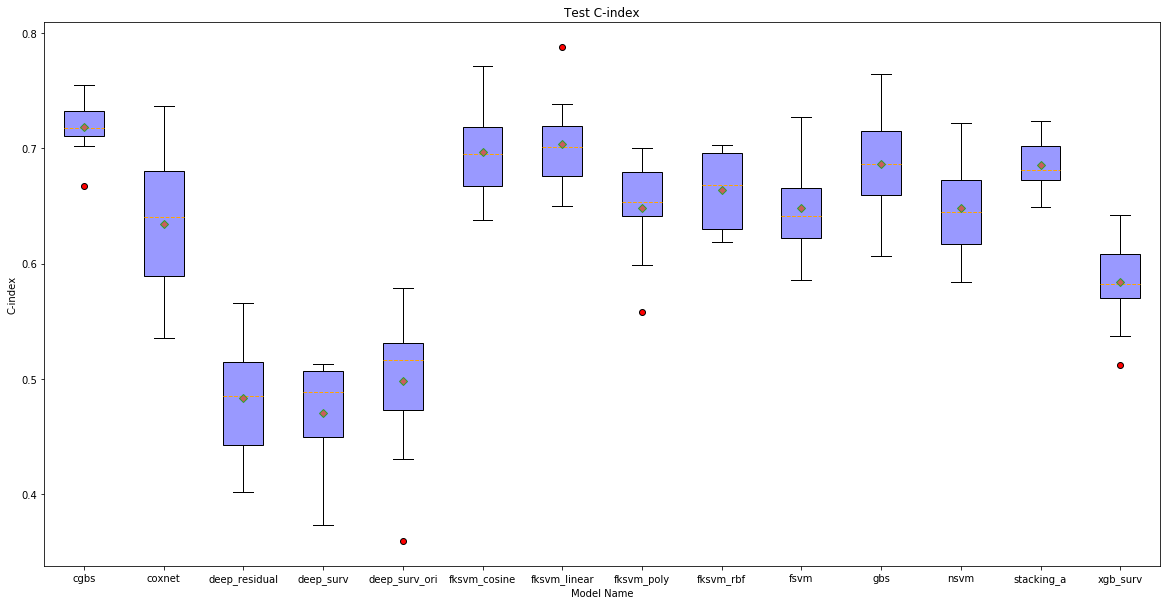

In [48]:
plt.figure(figsize=(20, 10));
plt.title('Test C-index')
plt.xlabel('Model Name')
plt.ylabel('C-index')
plt.boxplot(
    x = boxplot_data["test"],
    patch_artist=True,
    labels = boxplot_data["labels"],
    showmeans=True,
    boxprops = {'color':'black','facecolor':'#9999ff'},
    flierprops = {'marker':'o','markerfacecolor':'red','color':'black'},
    meanprops = {'marker':'D','markerfacecolor':'indianred'},
    medianprops = {'linestyle':'--','color':'orange'}
)